Twitter Bot Tweet 💻 🕷
Specifically created for Dimensional Table "Tweet"
Details that are important surrounding the tweet text.

DateTime of tweet when posted
Tweet ID of recorded tweet
Tweet in text format
Source of tweet posted
User Name of poster
User ID of poster

1. Import Dependencies
pytz library to access Olson tz database, which is a collection of time zones and their rules. This is the de facto standard for timezone information.
os library to gain ability to interact with operating system, in this case will be Google drive.
datetime module to allow for manipulation of date and time in python, also important datetime can handle timezones by using pytz library.
timezone module to provide a way to represent time zones, constructed with 2 arguments.

Import Libraries

In [1]:
import tweepy
import configparser as cp
import pandas as pd
import pytz
import psycopg2
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sqlalchemy import create_engine
from datetime import datetime


read configs

In [2]:
config = cp.RawConfigParser()
config.read('config.ini')
bt = config['twitter']['bearer_token']

api_key = config['twitter']['api_key']
api_secret = config['twitter']['api_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

authentication

In [3]:
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token,access_token_secret)

api = tweepy.API(auth)

client = tweepy.Client(bearer_token=bt)

Define the user and keywords to search for

In [4]:
user = "ElonMusk"
keywords = ["Free Speech", "Twitter"]

Define the date range

In [5]:
utc = pytz.timezone('UTC')
start_date = datetime(2019, 1, 1, tzinfo=utc)
end_date = datetime.now(utc)

create dataframe to house data scraped

In [6]:
columns = ['user_id', 'user_name', 'location', 'verified', 'followers_count']
data = []

Iterate over tweets and print those containing the keywords

In [7]:
for tweet in tweepy.Cursor(api.user_timeline, screen_name=user, tweet_mode='extended').items():
    tweet_datetime = tweet.created_at.replace(tzinfo=utc)
    if tweet_datetime < end_date and tweet_datetime > start_date:
        if any(keyword.lower() in tweet.full_text.lower() for keyword in keywords):
            data.append([tweet.user.id, tweet.user.screen_name, tweet.user.location, tweet.user.verified, tweet.user.followers_count])

dtu = pd.DataFrame(data, columns=columns)

Print result

In [8]:
dim_target_user = dtu.head(1)

print(dim_target_user)

    user_id user_name location  verified  followers_count
0  44196397  elonmusk               True        127423363


CREATE TABLE dim_target_user

In [9]:
%reload_ext sql
conn = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

conn.autocommit = True
cursor = conn.cursor()
create_table ='''
CREATE TABLE dim_target_user (
user_id numeric PRIMARY KEY,
user_name text,
location text,
verified boolean,
followers_count numeric
);
'''
cursor.execute(create_table)
print("SUCCESS!")

SUCCESS!


COMMIT DATA INTO DB

In [10]:
cursor = conn.cursor()

for index, row in dim_target_user.iterrows():
    cursor.execute("INSERT INTO dim_target_user (user_id, user_name, location, verified, followers_count) VALUES (%s, %s, %s, %s, %s)", (row['user_id'], row['user_name'], row['location'], row['verified'], row['followers_count']))

#Commit Changes
conn.commit()

CLOSE CONNECTION

In [11]:
cursor.close()
conn.close()

create dataframe to house data scraped for tweets

In [12]:
keyword_1 = "Free Speech"
keyword_2  = "Twitter"
columns = ['date', 'tweet_id', 'tweet', 'source', 'user_name', 'user_id', 'keyword_1', 'keyword_2']
data2 = []

Iterate over tweets and print those containing the keywords

In [13]:
for tweet in tweepy.Cursor(api.user_timeline, screen_name=user, tweet_mode='extended', exclude_replies=True, ).items():
    tweet_datetime = tweet.created_at.replace(tzinfo=utc)
    if tweet_datetime < end_date and tweet_datetime > start_date:
        kw1 = keyword_1.lower() in tweet.full_text.lower()
        kw2 = keyword_2.lower() in tweet.full_text.lower()
        if kw1 or kw2:
            data2.append([tweet_datetime, tweet.id, tweet.full_text, tweet.source, tweet.user.screen_name, tweet.user.id, kw1, kw2])

dim_tweets_w_keywords = pd.DataFrame(data2, columns=columns)

print result

In [14]:
print(dim_tweets_w_keywords)

                         date             tweet_id  \
0   2023-01-27 04:19:47+00:00  1618826074724634625   
1   2023-01-25 22:11:46+00:00  1618371072486936578   
2   2023-01-21 17:41:22+00:00  1616853475220156417   
3   2023-01-21 00:31:38+00:00  1616594332907372544   
4   2023-01-21 00:18:21+00:00  1616590989145313283   
..                        ...                  ...   
132 2022-10-26 18:45:58+00:00  1585341984679469056   
133 2022-10-26 15:27:40+00:00  1585292083610279936   
134 2022-10-12 21:09:41+00:00  1580304724082843648   
135 2022-10-04 22:39:41+00:00  1577428272056389633   
136 2022-09-13 17:45:44+00:00  1569744148881866758   

                                                 tweet              source  \
0                   Twitter is the PvP of social media  Twitter for iPhone   
1    Changed my name to Mr. Tweet, now Twitter won’...  Twitter for iPhone   
2    Ads are too frequent on Twitter and too big. T...  Twitter for iPhone   
3    Next Twitter update will remember 

DROP INDEX COLUMN

In [15]:
new = dim_tweets_w_keywords.reset_index(drop=True)
display(new)

,date,tweet_id,tweet,source,user_name,user_id,keyword_1,keyword_2
0,2023-01-27 04:19:47+00:00,1618826074724634625,Twitter is the PvP of social media,Twitter for iPhone,elonmusk,44196397,False,True
1,2023-01-25 22:11:46+00:00,1618371072486936578,"Changed my name to Mr. Tweet, now Twitter won’...",Twitter for iPhone,elonmusk,44196397,False,True
2,2023-01-21 17:41:22+00:00,1616853475220156417,Ads are too frequent on Twitter and too big. T...,Twitter for iPhone,elonmusk,44196397,False,True
3,2023-01-21 00:31:38+00:00,1616594332907372544,Next Twitter update will remember whether you ...,Twitter for iPhone,elonmusk,44196397,False,True
4,2023-01-21 00:18:21+00:00,1616590989145313283,"In coming months, Twitter will translate &amp;...",Twitter for iPhone,elonmusk,44196397,False,True
...,...,...,...,...,...,...,...,...
132,2022-10-26 18:45:58+00:00,1585341984679469056,Entering Twitter HQ – let that sink in! https:...,Twitter for iPhone,elonmusk,44196397,False,True
133,2022-10-26 15:27:40+00:00,1585292083610279936,A beautiful thing about Twitter is how it empo...,Twitter for iPhone,elonmusk,44196397,False,True
134,2022-10-12 21:09:41+00:00,1580304724082843648,"Please buy my perfume, so I can buy Twitter",Twitter for iPhone,elonmusk,44196397,False,True
135,2022-10-04 22:39:41+00:00,1577428272056389633,"Buying Twitter is an accelerant to creating X,...",Twitter for iPhone,elonmusk,44196397,False,True


FILTER AWAY RETWEETS AND SAVE TO CSV FILE

In [16]:
new.drop(new[new['tweet'].str.contains('RT')].index,inplace=True)
display(new)
#new.to_csv('dim_tweets_w_keyword.csv', index=False, header=True)

,date,tweet_id,tweet,source,user_name,user_id,keyword_1,keyword_2
0,2023-01-27 04:19:47+00:00,1618826074724634625,Twitter is the PvP of social media,Twitter for iPhone,elonmusk,44196397,False,True
1,2023-01-25 22:11:46+00:00,1618371072486936578,"Changed my name to Mr. Tweet, now Twitter won’...",Twitter for iPhone,elonmusk,44196397,False,True
2,2023-01-21 17:41:22+00:00,1616853475220156417,Ads are too frequent on Twitter and too big. T...,Twitter for iPhone,elonmusk,44196397,False,True
3,2023-01-21 00:31:38+00:00,1616594332907372544,Next Twitter update will remember whether you ...,Twitter for iPhone,elonmusk,44196397,False,True
4,2023-01-21 00:18:21+00:00,1616590989145313283,"In coming months, Twitter will translate &amp;...",Twitter for iPhone,elonmusk,44196397,False,True
...,...,...,...,...,...,...,...,...
132,2022-10-26 18:45:58+00:00,1585341984679469056,Entering Twitter HQ – let that sink in! https:...,Twitter for iPhone,elonmusk,44196397,False,True
133,2022-10-26 15:27:40+00:00,1585292083610279936,A beautiful thing about Twitter is how it empo...,Twitter for iPhone,elonmusk,44196397,False,True
134,2022-10-12 21:09:41+00:00,1580304724082843648,"Please buy my perfume, so I can buy Twitter",Twitter for iPhone,elonmusk,44196397,False,True
135,2022-10-04 22:39:41+00:00,1577428272056389633,"Buying Twitter is an accelerant to creating X,...",Twitter for iPhone,elonmusk,44196397,False,True


CONNECT TO DATABASE AND CREATE TABLE

In [17]:
%reload_ext sql
conn = psycopg2.connect(
host="localhost",
port = 5432,
user = "postgres",
password = '!Jehuty1988',
database='postgres')

conn.autocommit = True
cursor = conn.cursor()
create_table ='''
CREATE TABLE dim_tweets_w_keywords (
date date,
tweet_id numeric PRIMARY KEY,
tweet varchar,
source varchar,
user_name varchar,
user_id numeric,
keyword_1 boolean,
keyword_2 boolean
);
'''
cursor.execute(create_table)
print("SUCCESS!")

SUCCESS!


INSERT DATAFRAME INTO TABLE IN DATABASE

In [18]:
# Connect to the database
connection = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

cursor = conn.cursor()

for index, row in new.iterrows():
    cursor.execute("INSERT INTO dim_tweets_w_keywords (date, tweet_id, tweet, source, user_name, user_id, keyword_1, keyword_2) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", (row['date'], row['tweet_id'], row['tweet'], row['source'], row['user_name'], row['user_id'], row['keyword_1'], row['keyword_2']))

#Commit Changes
conn.commit()

CLOSE CONNECTION

In [19]:
# Close the connection
cursor.close()
conn.close()

connect to database and extract list of tweet ids

In [20]:
# Connect to the database
conn = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

cursor = conn.cursor()

cursor.execute("SELECT tweet_id FROM dim_tweets_w_keywords")

# Fetch all rows from the query
rows = cursor.fetchall()

# Close the cursor and connection
cursor.close()
conn.close()

#print(rows)

# Extract the column and put it into a list
column_list = [row[0] for row in rows]

# Use list comprehension to convert all elements to float
tweet_id_list = [int(i) for i in column_list]

# Print the list
print(tweet_id_list)

[1618826074724634625, 1618371072486936578, 1616853475220156417, 1616594332907372544, 1616590989145313283, 1616533691156819968, 1616531077790826497, 1616524886201225217, 1616179085507702785, 1615398789585731587, 1614761844010528770, 1613995936585519104, 1610374789759205380, 1609109899233071104, 1608922473839620096, 1608663342956302337, 1608324539779551232, 1608175680407191552, 1607416119496945665, 1606396336592498688, 1605957811162054656, 1605738005813084165, 1605219914813673473, 1605219196350222339, 1604999237099716609, 1604617643973124097, 1604486844867133442, 1603985491505795072, 1603852159283445760, 1603659604906213376, 1602387025855885312, 1601866862505381888, 1601861909736607744, 1601667312930590721, 1601395677845544960, 1601124219009409024, 1601042125130371072, 1601020109807448064, 1599840937298968576, 1599261195470372866, 1599258460121538560, 1599228101547868160, 1599205091294052352, 1598989666812071936, 1598864377750306816, 1598778884639653891, 1598770563597606917, 159876563312

Create and store tweet details

In [21]:
data = []
columns = ['tweet_id','retweets','likes']

for i in tweet_id_list:
    tweet = api.get_status(i)
    retweets = tweet.retweet_count
    likes = tweet.favorite_count
    data.append([i,tweet.retweet_count,tweet.favorite_count])
tweet_details = pd.DataFrame(data, columns=columns)
#tweet_details_list = [float(i) for i in tweet_details]
display(tweet_details)

,tweet_id,retweets,likes
0,1618826074724634625,8304,76648
1,1618371072486936578,52509,832574
2,1616853475220156417,15589,256521
3,1616594332907372544,6765,76132
4,1616590989145313283,25554,292930
...,...,...,...
117,1585341984679469056,180602,1377206
118,1585292083610279936,45902,374717
119,1580304724082843648,41603,575208
120,1577428272056389633,35494,417026


CONNECT TO DATABASE AND CREATE dim_correlation TABLE

In [22]:
%reload_ext sql
conn = psycopg2.connect(
host="localhost",
port = 5432,
user = "postgres",
password = '!Jehuty1988',
database='postgres')

conn.autocommit = True
cursor = conn.cursor()
create_table ='''
CREATE TABLE dim_correlation (
tweet_id numeric,
retweets int,
likes int,
correlation_id serial PRIMARY KEY
);
'''
cursor.execute(create_table)
print("SUCCESS!")

SUCCESS!


Populate dim_correlation Table

In [23]:
cursor = conn.cursor()

#tweet_details['tweet_id'] = tweet_details['tweet_id'].astype(int)
#tweet_details['retweets'] = tweet_details['retweets'].astype(int)
#tweet_details['likes'] = tweet_details['likes'].astype(int)

for index, row in tweet_details.iterrows():
    cursor.execute("INSERT INTO dim_correlation (tweet_id, retweets, likes) VALUES (%s, %s, %s)", (int(row['tweet_id']), int(row['retweets']), int(row['likes'])))
    
conn.commit()  

CLOSE CONNECTION

In [24]:
cursor.close()
conn.close()

FIND CORRELATION BETWEEN RETWEETS AND LIKES.

In [25]:
conn = psycopg2.connect( 
    host='localhost', 
    port=5432, 
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres' 
    ) 
    
cur = conn.cursor() 

query = """
SELECT
    CASE
        WHEN CORR(dc.retweets, dc.likes) > 0 THEN 'True'
    ELSE 'False'
    END AS correlated
FROM dim_correlation AS dc
"""

cur.execute(query)
result = cur.fetchall()

conn.commit()

correlated = pd.DataFrame(result)
display(correlated)

,0
0,True


RETRIEVE TWEET IDS FOR QUOTED TWEETS EXTRACTION

In [26]:
# Connect to the database
conn = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

cursor = conn.cursor()

cursor.execute("SELECT tweet_id FROM dim_correlation")

# Fetch all rows from the query
rows = cursor.fetchall()

# Close the cursor and connection
cursor.close()
conn.close()

#print(rows)

# Extract the column and put it into a list
column_list = [row[0] for row in rows]

# Use list comprehension to convert all elements to float
tweet_id_list = [int(i) for i in column_list]

# Print the list
print(tweet_id_list)

[1618826074724634625, 1618371072486936578, 1616853475220156417, 1616594332907372544, 1616590989145313283, 1616533691156819968, 1616531077790826497, 1616524886201225217, 1616179085507702785, 1615398789585731587, 1614761844010528770, 1613995936585519104, 1610374789759205380, 1609109899233071104, 1608922473839620096, 1608663342956302337, 1608324539779551232, 1608175680407191552, 1607416119496945665, 1606396336592498688, 1605957811162054656, 1605738005813084165, 1605219914813673473, 1605219196350222339, 1604999237099716609, 1604617643973124097, 1604486844867133442, 1603985491505795072, 1603852159283445760, 1603659604906213376, 1602387025855885312, 1601866862505381888, 1601861909736607744, 1601667312930590721, 1601395677845544960, 1601124219009409024, 1601042125130371072, 1601020109807448064, 1599840937298968576, 1599261195470372866, 1599258460121538560, 1599228101547868160, 1599205091294052352, 1598989666812071936, 1598864377750306816, 1598778884639653891, 1598770563597606917, 159876563312

CREATE EMPTY DATAFRAME AND LIMIT SAMPLE SIZE TO 20 TWEET IDs

In [27]:
sample = []

# Print the list
for x in tweet_id_list[:20]:
    sample.append(x)
    
display(sample)

[1618826074724634625,
 1618371072486936578,
 1616853475220156417,
 1616594332907372544,
 1616590989145313283,
 1616533691156819968,
 1616531077790826497,
 1616524886201225217,
 1616179085507702785,
 1615398789585731587,
 1614761844010528770,
 1613995936585519104,
 1610374789759205380,
 1609109899233071104,
 1608922473839620096,
 1608663342956302337,
 1608324539779551232,
 1608175680407191552,
 1607416119496945665,
 1606396336592498688]

FOR EVERY TWEET ID, RETRIEVE 25 QUOTE TWEET IDs AND THEIR CONTENT

In [28]:
data = []
cols = ['tweet_id','quoted_tweet_id','content']

for i in sample:
    # Replace the limit=1000 with the maximum number of Tweets you want
    for tweet in tweepy.Paginator(client.get_quote_tweets, id = i,
                              max_results=25, exclude='retweets').flatten(limit=25):
        data.append([i,tweet.id, tweet.text])
    tweet_details = pd.DataFrame(data, columns=cols)
display(tweet_details)

,tweet_id,quoted_tweet_id,content
0,1618826074724634625,1618868807795367936,Χειρότερος κι απ' τις μλκίες των 🦖 έχεις καταν...
1,1618826074724634625,1618868692095471616,esse elon musk ainda mandou o papo agora https...
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...
...,...,...,...
495,1606396336592498688,1607863591293558785,хаха блчть https://t.co/V5lG12zLUv
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe..."
498,1606396336592498688,1607796965890457600,Yesssss https://t.co/KwD03VTY4j


CHECK IF THE QUOTE TWEET ID IS VALID AND RETRIEVE THE TWEET ID

In [29]:
status = api.get_status(1616400682881269760, tweet_mode='extended')
if hasattr(status,'quoted_status'):
    quoted_tweet_id = status.quoted_status.id
    print(quoted_tweet_id)
    
# quoted_status = api.get_status(1616216911318241284)
# quoted_text = quoted_status.text    
# print(f'nnn {quoted_text}')

1616179085507702785


CLEAN TWEETS

In [30]:
def cleanTweets(tweet):
    tweet = re.sub('RT', '', tweet)
    tweet = re.sub('@[\S]*', ' ', tweet) #Remove mentions
    tweet = re.sub(r'https\S+', '', tweet) #Remove hyperlinks2
    tweet = re.sub(r'https?\/\/\S+', '', tweet) #Remove hyperlinks
    tweet = re.sub(r'&amp',' ', tweet) #Remove &amp
    tweet = re.sub('#[A-Za-z0-9]+', ' ', tweet) #Remove special characters
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet) #Remove non-English words
    tweet = re.sub(r"(.)\1{2,}", r"\1", tweet) #Remove 3 repeating characters
    tweet = re.sub('[^\w\s]+',' ', tweet) #Remove punctuation
    tweet = re.sub('\n', '', tweet) #Remove newlines
    tweet = re.sub(' +', ' ', tweet) #Remove whitespaces
    tweet = re.sub('^[\s]+|[\s]+$', '', tweet) #Remove whitespaces
    return tweet

tweet_details['cleaned'] = tweet_details['content'].apply(cleanTweets)
display(tweet_details)

,tweet_id,quoted_tweet_id,content,cleaned
0,1618826074724634625,1618868807795367936,Χειρότερος κι απ' τις μλκίες των 🦖 έχεις καταν...,
1,1618826074724634625,1618868692095471616,esse elon musk ainda mandou o papo agora https...,esse elon musk ainda mandou o papo agora
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,TS is also but I want to make this for the bet...
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,This guy gets it
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,This mf say ANYTHING AND EVERYTHING ABOUT NUTHIN
...,...,...,...,...
495,1606396336592498688,1607863591293558785,хаха блчть https://t.co/V5lG12zLUv,
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,Hahahaha what an idiot but great job destroyin...
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",You know what I am a bird and I m not register...
498,1606396336592498688,1607796965890457600,Yesssss https://t.co/KwD03VTY4j,Yes


Create new data frame (tw_list) and a new feature(text), then clean text by using lambda function and clean RT, link, punctuation characters and finally convert to lowercase.

In [31]:
#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_details)
tw_list['cleaned'] = tw_list['cleaned'].str.lower() # Make Tweets lower case
tw_list['cleaned'] = tw_list['cleaned'].str.strip() # Remove trailing white space
tw_list.head(10)

,tweet_id,quoted_tweet_id,content,cleaned
0,1618826074724634625,1618868807795367936,Χειρότερος κι απ' τις μλκίες των 🦖 έχεις καταν...,
1,1618826074724634625,1618868692095471616,esse elon musk ainda mandou o papo agora https...,esse elon musk ainda mandou o papo agora
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts is also but i want to make this for the bet...
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,this guy gets it
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,this mf say anything and everything about nuthin
5,1618826074724634625,1618868206294401024,レイドボスが何か言ってらあ。 https://t.co/YHNYDLvdrx,
6,1618826074724634625,1618868047359660032,Yeap! https://t.co/29fo1XVrxD,yeap
7,1618826074724634625,1618868002468012034,sim! HAHAHAHAH https://t.co/rhPMdWs1Q2,sim hahahahah
8,1618826074724634625,1618867909513846785,No le falta razón… https://t.co/t34g4ce7av,no le falta raz n
9,1618826074724634625,1618867877582614528,💯 https://t.co/Sftb1QzYqo,


To check if Tweets are in English, and delete non-English Tweets

In [33]:
from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
    
tw_list['is_english'] = tw_list['cleaned'].apply(is_english)
tw_list.drop(tw_list[tw_list['is_english'] == False].index, inplace=True)

display(tw_list)

,tweet_id,quoted_tweet_id,content,cleaned,is_english
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts is also but i want to make this for the bet...,True
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,this guy gets it,True
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,this mf say anything and everything about nuthin,True
13,1618826074724634625,1618866544725090304,"sir @elonmusk we introduce ourselves, we are a...",sir we introduce ourselves we are a women s es...,True
14,1618826074724634625,1618866430614859777,This statement suggests that Twitter is a part...,this statement suggests that twitter is a part...,True
...,...,...,...,...,...
492,1606396336592498688,1608016755427004417,https://t.co/VcAwKJmjW9\n\nNah he's hilarious,nah he s hilarious,True
493,1606396336592498688,1607898321892552705,First time in a long time.... https://t.co/RjS...,first time in a long time,True
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,hahahaha what an idiot but great job destroyin...,True
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",you know what i am a bird and i m not register...,True


Remove is_english col

In [34]:
tw_list.pop("is_english")

display(tw_list)

,tweet_id,quoted_tweet_id,content,cleaned
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts is also but i want to make this for the bet...
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,this guy gets it
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,this mf say anything and everything about nuthin
13,1618826074724634625,1618866544725090304,"sir @elonmusk we introduce ourselves, we are a...",sir we introduce ourselves we are a women s es...
14,1618826074724634625,1618866430614859777,This statement suggests that Twitter is a part...,this statement suggests that twitter is a part...
...,...,...,...,...
492,1606396336592498688,1608016755427004417,https://t.co/VcAwKJmjW9\n\nNah he's hilarious,nah he s hilarious
493,1606396336592498688,1607898321892552705,First time in a long time.... https://t.co/RjS...,first time in a long time
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,hahahaha what an idiot but great job destroyin...
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",you know what i am a bird and i m not register...


To remove stopwords from Tweets

In [35]:
nltk.download('stopwords')

stopwords_list = set(stopwords.words('english'))
tw_list['cleaned'] = tw_list['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords_list]))

display(tw_list)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bizbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet_id,quoted_tweet_id,content,cleaned
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts also want make better
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,guy gets
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,mf say anything everything nuthin
13,1618826074724634625,1618866544725090304,"sir @elonmusk we introduce ourselves, we are a...",sir introduce women esports team looking give ...
14,1618826074724634625,1618866430614859777,This statement suggests that Twitter is a part...,statement suggests twitter particularly compet...
...,...,...,...,...
492,1606396336592498688,1608016755427004417,https://t.co/VcAwKJmjW9\n\nNah he's hilarious,nah hilarious
493,1606396336592498688,1607898321892552705,First time in a long time.... https://t.co/RjS...,first time long time
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,hahahaha idiot great job destroying billions m...
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",know bird registered right county even vote ev...


Drop duplicates inplace

In [36]:
cleaned_tw_list = tw_list.drop_duplicates(subset=['cleaned'])
print('Result DataFrame:\n', cleaned_tw_list)
cleaned_tw_list = cleaned_tw_list.dropna(subset=['cleaned'])
display(cleaned_tw_list)
cleaned_tw_list.shape
# cleaned_tw_list.to_csv(fr"C:\Users\kylel\OneDrive\Desktop\BIDA\00 Interim Project\Project Files\cleaned_tw_list.csv", index=True)

Result DataFrame:
                 tweet_id      quoted_tweet_id  \
2    1618826074724634625  1618868557240233986   
3    1618826074724634625  1618868515158761473   
4    1618826074724634625  1618868456555974657   
13   1618826074724634625  1618866544725090304   
14   1618826074724634625  1618866430614859777   
..                   ...                  ...   
492  1606396336592498688  1608016755427004417   
493  1606396336592498688  1607898321892552705   
496  1606396336592498688  1607844739726086144   
497  1606396336592498688  1607812840945246208   
499  1606396336592498688  1607760148763746304   

                                               content  \
2    TS is also but I want to make this for the bet...   
3            This guy gets it. https://t.co/KNfMJAR41p   
4    This mf say ANYTHING AND EVERYTHING ABOUT NUTH...   
13   sir @elonmusk we introduce ourselves, we are a...   
14   This statement suggests that Twitter is a part...   
..                                          

,tweet_id,quoted_tweet_id,content,cleaned
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts also want make better
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,guy gets
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,mf say anything everything nuthin
13,1618826074724634625,1618866544725090304,"sir @elonmusk we introduce ourselves, we are a...",sir introduce women esports team looking give ...
14,1618826074724634625,1618866430614859777,This statement suggests that Twitter is a part...,statement suggests twitter particularly compet...
...,...,...,...,...
492,1606396336592498688,1608016755427004417,https://t.co/VcAwKJmjW9\n\nNah he's hilarious,nah hilarious
493,1606396336592498688,1607898321892552705,First time in a long time.... https://t.co/RjS...,first time long time
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,hahahaha idiot great job destroying billions m...
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",know bird registered right county even vote ev...


(277, 4)

CONNECT TO DB AND CREATE TABLE

In [37]:
%reload_ext sql
conn = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

conn.autocommit = True
cursor = conn.cursor()
create_table ='''
CREATE TABLE cleaned_twt_list (
tweet_id numeric,
quoted_tweet_id numeric,
content text,
cleaned text
);
'''
cursor.execute(create_table)
print("SUCCESS!")

SUCCESS!


INSERT DATAFRAME INTO CREATED TABLE IN POSTGRES

In [38]:
# Connect to the database
conn = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

cursor = conn.cursor()

for index, row in cleaned_tw_list.iterrows():
    cursor.execute("INSERT INTO cleaned_twt_list (tweet_id, quoted_tweet_id, content, cleaned) VALUES (%s, %s, %s, %s)", (row['tweet_id'], row['quoted_tweet_id'], row['content'], row['cleaned']))


#Commit Changes
conn.commit()

CLOSE CONNECTION

In [39]:
cursor.close()
conn.close()

Generate wordcloud

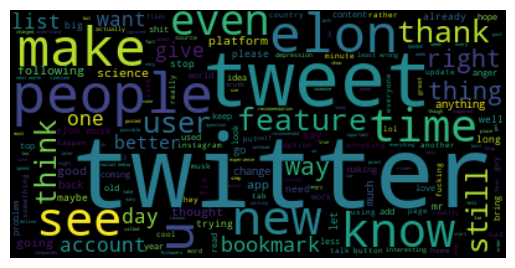

In [40]:
# Read in your dataframe
#df = pd.read_csv('cleaned_tw_list.csv')

# Convert the relevant column of the dataframe into a string of text
text = ' '.join(cleaned_tw_list['cleaned'].tolist())

# Generate the word cloud
wordcloud = WordCloud().generate(text)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ANALYSE Sentiments

In [41]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
cleaned_tw_list['compound'] = [analyzer.polarity_scores(x)['compound'] for x in cleaned_tw_list['cleaned']]
cleaned_tw_list['neg'] = [analyzer.polarity_scores(x)['neg'] for x in cleaned_tw_list['cleaned']]
cleaned_tw_list['neu'] = [analyzer.polarity_scores(x)['neu'] for x in cleaned_tw_list['cleaned']]
cleaned_tw_list['pos'] = [analyzer.polarity_scores(x)['pos'] for x in cleaned_tw_list['cleaned']]

display(cleaned_tw_list)

,tweet_id,quoted_tweet_id,content,cleaned,compound,neg,neu,pos
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts also want make better,0.4939,0.000,0.417,0.583
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,guy gets,0.0000,0.000,1.000,0.000
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,mf say anything everything nuthin,0.0000,0.000,1.000,0.000
13,1618826074724634625,1618866544725090304,"sir @elonmusk we introduce ourselves, we are a...",sir introduce women esports team looking give ...,0.1779,0.107,0.711,0.182
14,1618826074724634625,1618866430614859777,This statement suggests that Twitter is a part...,statement suggests twitter particularly compet...,0.2006,0.157,0.629,0.214
...,...,...,...,...,...,...,...,...
492,1606396336592498688,1608016755427004417,https://t.co/VcAwKJmjW9\n\nNah he's hilarious,nah hilarious,0.3182,0.341,0.000,0.659
493,1606396336592498688,1607898321892552705,First time in a long time.... https://t.co/RjS...,first time long time,0.0000,0.000,1.000,0.000
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,hahahaha idiot great job destroying billions m...,-0.1027,0.397,0.230,0.374
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",know bird registered right county even vote ev...,0.3612,0.000,0.902,0.098


DETERMINE THRESHOLD

positive sentiment : (compound score >= 0.05)

neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 

negative sentiment : (compound score <= -0.05)

In [42]:
cleaned_tw_list['sentiment'] = ['positive' if x >= 0.05 else 'neutral' if x > -0.05 and x < 0.05 else 'negative' for x in cleaned_tw_list['compound']]

display(cleaned_tw_list)

,tweet_id,quoted_tweet_id,content,cleaned,compound,neg,neu,pos,sentiment
2,1618826074724634625,1618868557240233986,TS is also but I want to make this for the bet...,ts also want make better,0.4939,0.000,0.417,0.583,positive
3,1618826074724634625,1618868515158761473,This guy gets it. https://t.co/KNfMJAR41p,guy gets,0.0000,0.000,1.000,0.000,neutral
4,1618826074724634625,1618868456555974657,This mf say ANYTHING AND EVERYTHING ABOUT NUTH...,mf say anything everything nuthin,0.0000,0.000,1.000,0.000,neutral
13,1618826074724634625,1618866544725090304,"sir @elonmusk we introduce ourselves, we are a...",sir introduce women esports team looking give ...,0.1779,0.107,0.711,0.182,positive
14,1618826074724634625,1618866430614859777,This statement suggests that Twitter is a part...,statement suggests twitter particularly compet...,0.2006,0.157,0.629,0.214,positive
...,...,...,...,...,...,...,...,...,...
492,1606396336592498688,1608016755427004417,https://t.co/VcAwKJmjW9\n\nNah he's hilarious,nah hilarious,0.3182,0.341,0.000,0.659,positive
493,1606396336592498688,1607898321892552705,First time in a long time.... https://t.co/RjS...,first time long time,0.0000,0.000,1.000,0.000,neutral
496,1606396336592498688,1607844739726086144,Hahahaha 🙄 what an idiot - but great job destr...,hahahaha idiot great job destroying billions m...,-0.1027,0.397,0.230,0.374,negative
497,1606396336592498688,1607812840945246208,"You know what, I am a bird and I'm not registe...",know bird registered right county even vote ev...,0.3612,0.000,0.902,0.098,positive


CREATE TABLE for dim_sentiments

In [43]:
%reload_ext sql
conn = psycopg2.connect(
    host='localhost', 
    port=5432,
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres'
)

conn.autocommit = True
cursor = conn.cursor()
create_table ='''
CREATE TABLE dim_sentiments (
sentiment_id serial PRIMARY KEY,
tweet_id numeric,
quoted_tweet_id numeric,
cleaned text,
neg numeric,
neu numeric,
pos numeric,
compound double precision,
sentiment text

);
'''
cursor.execute(create_table)
print("SUCCESS!")

SUCCESS!


COMMIT TABLE INFORMATION

In [44]:
dim_sentiments = pd.DataFrame(cleaned_tw_list)
cursor = conn.cursor()

for index, row in dim_sentiments.iterrows():
    cursor.execute("INSERT INTO dim_sentiments (tweet_id, quoted_tweet_id, cleaned, neg, neu, pos, compound, sentiment) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)", (row['tweet_id'], row['quoted_tweet_id'], row['cleaned'], row['neg'], row['neu'], row['pos'], row['compound'], row['sentiment']))

#Commit Changes
conn.commit()

CLOSE CONNECTION

In [45]:
cursor.close()
conn.close()

Count values for sentiment features and see total — percentage.

In [46]:
# Count the number of neutral, positive and negative sentiments
sentiment_count = cleaned_tw_list['sentiment'].value_counts()

# Create a new dataframe to store the results
result_df = pd.DataFrame(columns=['Sentiment', 'Total', 'Percentage'])

# Loop through the sentiment_count to add the values to the result_df
for sentiment, count in sentiment_count.items():
    percentage = count / len(cleaned_tw_list) * 100
    new_row = pd.DataFrame({'Sentiment': [sentiment], 'Total': [count], 'Percentage': [percentage]})
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    
print(result_df)

  Sentiment Total  Percentage
0  positive   122   44.043321
1   neutral    98   35.379061
2  negative    57   20.577617


CREATE PIE TO VISUALISE SENTIMENTS

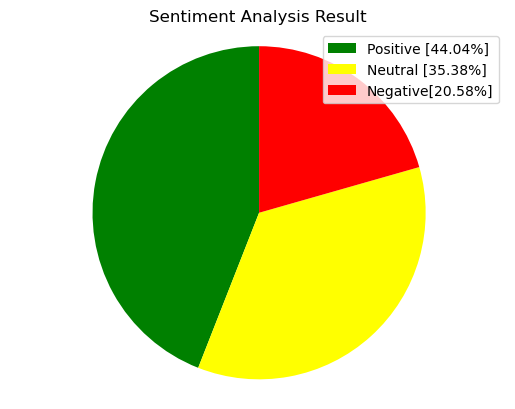

In [47]:
#Creating PieChart

piechart = result_df

labels = ['Positive', 'Neutral','Negative']
sizes = result_df.Percentage
colors = ['green', 'yellow','red']

#Formatting labels with percentages
labels = ['Positive ['+str(round(sizes[0],2))+'%]' , 'Neutral ['+str(round(sizes[1],2))+'%]','Negative['+str(round(sizes[2],2))+'%]']

patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(patches, labels, loc="best")
plt.title("Sentiment Analysis Result" )
plt.axis('equal')
plt.show()

#This code will update the pie chart based on the values in the "sentiment" column of the cleaned_tw_list, and also display the percentages in the labels.

Create Table to house query result

In [48]:
conn = psycopg2.connect( 
    host='localhost', 
    port=5432, 
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres' 
    ) 
    
cur = conn.cursor() 

# Create a cursor object
cur = conn.cursor()

# Define the table and columns
table_name = 'general_sentiments'
columns = ['tweet_id numeric', 'general_sentiment text']

# Create the table
cur.execute(f"CREATE TABLE {table_name} ({', '.join(columns)})")

# Commit changes and close the connection
conn.commit()
conn.close()

Figuring out General Sentiments from calculating sentiments column in dim_sentiments

In [49]:
conn = psycopg2.connect( 
    host='localhost', 
    port=5432, 
    user='postgres', 
    password='!Jehuty1988', 
    dbname='postgres' 
    ) 
    
cur = conn.cursor() 

# First query
query1 = """
SELECT 
    tweet_id, 
    COUNT(CASE WHEN sentiment = 'neutral' THEN 1 END) AS neutral_count, 
    COUNT(CASE WHEN sentiment = 'positive' THEN 1 END) AS positive_count, 
    COUNT(CASE WHEN sentiment = 'negative' THEN 1 END) AS negative_count
FROM  dim_sentiments
GROUP BY tweet_id
"""

cur.execute(query1) 
result1 = cur.fetchall() 

# Second query
query2 = """
SELECT 
    tweet_id,
    COUNT(CASE WHEN sentiment = 'neutral' THEN 1 END) AS neutral_count, 
    COUNT(CASE WHEN sentiment = 'positive' THEN 1 END) AS positive_count, 
    COUNT(CASE WHEN sentiment = 'negative' THEN 1 END) AS negative_count,
    (COUNT(CASE WHEN sentiment = 'positive' THEN 1 END)*100.0 / COUNT(*)) AS positive_percent,
    (COUNT(CASE WHEN sentiment = 'neutral' THEN 1 END)*100.0 / COUNT(*)) AS neutral_percent,
    (COUNT(CASE WHEN sentiment = 'negative' THEN 1 END)*100.0 / COUNT(*)) AS negative_percent,
    CASE 
      WHEN (COUNT(CASE WHEN sentiment = 'positive' THEN 1 END)*100.0 / COUNT(*)) > 66 THEN 'strongly positive'
      WHEN (COUNT(CASE WHEN sentiment = 'positive' THEN 1 END)*100.0 / COUNT(*)) > 33 THEN 'positive'
      WHEN (COUNT(CASE WHEN sentiment = 'neutral' THEN 1 END)*100.0 / COUNT(*)) > 33 THEN 'neutral'
      WHEN (COUNT(CASE WHEN sentiment = 'negative' THEN 1 END)*100.0 / COUNT(*)) > 33 THEN 'negative'
      ELSE 'strongly negative'
    END AS general_sentiment
FROM dim_sentiments
GROUP BY tweet_id
"""

cur.execute(query2)
result2 = cur.fetchall()

conn.commit()

column_names = [desc[0] for desc in cur.description]
general_sentiments = pd.DataFrame(result2, columns = column_names)
display(general_sentiments)

,tweet_id,neutral_count,positive_count,negative_count,positive_percent,neutral_percent,negative_percent,general_sentiment
0,1616533691156819968,6,8,0,57.1428571428571429,42.8571428571428571,0E-20,positive
1,1618371072486936578,6,4,4,28.5714285714285714,42.8571428571428571,28.5714285714285714,neutral
2,1607416119496945665,7,3,3,23.0769230769230769,53.8461538461538462,23.0769230769230769,neutral
3,1608324539779551232,5,3,1,33.3333333333333333,55.5555555555555556,11.1111111111111111,positive
4,1613995936585519104,7,7,0,50.0000000000000000,50.0000000000000000,0E-20,positive
5,1616524886201225217,5,11,2,61.1111111111111111,27.7777777777777778,11.1111111111111111,positive
6,1609109899233071104,4,7,2,53.8461538461538462,30.7692307692307692,15.3846153846153846,positive
7,1610374789759205380,4,4,3,36.3636363636363636,36.3636363636363636,27.2727272727272727,positive
8,1614761844010528770,4,6,7,35.2941176470588235,23.5294117647058824,41.1764705882352941,positive
9,1606396336592498688,4,5,2,45.4545454545454545,36.3636363636363636,18.1818181818181818,positive


In [50]:

cursor = conn.cursor()

for index, row in general_sentiments.iterrows():
    cursor.execute("INSERT INTO general_sentiments (tweet_id, general_sentiment) VALUES (%s, %s)", (row['tweet_id'], row['general_sentiment']))

#Commit Changes
conn.commit()


Close Connection

In [51]:
cur.close()
conn.close()

Create Fact Table

In [52]:
conn = psycopg2.connect(
host='localhost',
port=5432,
user='postgres',
password='!Jehuty1988',
dbname='postgres'
)
cur = conn.cursor()

query = """
SELECT dtu.user_id, dtu.user_name, dtwk.tweet_id, dtwk.tweet, gs.general_sentiment, 'perception_id'
FROM dim_target_user AS dtu
INNER JOIN dim_tweets_w_keywords AS dtwk ON dtu.user_id = dtwk.user_id
INNER JOIN dim_correlation AS dc ON dtwk.tweet_id = dc.tweet_id
INNER JOIN general_sentiments AS gs ON dc.tweet_id = gs.tweet_id
"""

cur.execute(query)
result = cur.fetchall()

conn.commit()

fact_public_perception = pd.DataFrame(result, columns = ['user_id', 'user_name', 'tweet_id', 'tweet', 'general_sentiment', 'perception_id'])
display(fact_public_perception)

,user_id,user_name,tweet_id,tweet,general_sentiment,perception_id
0,44196397,elonmusk,1616533691156819968,Major Twitter improvement we just released is ...,positive,perception_id
1,44196397,elonmusk,1618371072486936578,"Changed my name to Mr. Tweet, now Twitter won’...",neutral,perception_id
2,44196397,elonmusk,1607416119496945665,Much more to The Twitter Files: Covid Editon t...,neutral,perception_id
3,44196397,elonmusk,1608324539779551232,Significant backend server architecture change...,positive,perception_id
4,44196397,elonmusk,1613995936585519104,Twitter will publish tweet recommendation code...,positive,perception_id
5,44196397,elonmusk,1616524886201225217,Use pinned Lists to improve your Twitter exper...,positive,perception_id
6,44196397,elonmusk,1609109899233071104,Twitter has a bookmark function accessible thr...,positive,perception_id
7,44196397,elonmusk,1610374789759205380,Another episode of The Twitter Files https://t...,positive,perception_id
8,44196397,elonmusk,1614761844010528770,Instagram makes people depressed &amp; Twitter...,positive,perception_id
9,44196397,elonmusk,1606396336592498688,Twitter votes for the right haha https://t.co/...,positive,perception_id


In [53]:
conn = psycopg2.connect(
    host='localhost',
    port=5432,
    user='postgres',
    password='!Jehuty1988',
    dbname='postgres'
)

cur = conn.cursor()

query = """
CREATE TABLE fact_public_perception (
    perception_id SERIAL,
    user_id numeric,
    user_name text,
    tweet_id numeric,
    tweet text,
    general_sentiment text,
    PRIMARY KEY (perception_id),
    FOREIGN KEY (user_id) REFERENCES dim_target_user(user_id),
    FOREIGN KEY (tweet_id) REFERENCES dim_tweets_w_keywords(tweet_id)
);
"""

cur.execute(query)
conn.commit()

Commit query and populate fact table

In [54]:
cursor = conn.cursor()

for index, row in fact_public_perception.iterrows():
    cursor.execute("INSERT INTO fact_public_perception (user_id,  user_name, tweet_id, tweet, general_sentiment) VALUES (%s, %s, %s, %s, %s)", (row['user_id'], row['user_name'], row['tweet_id'], row['tweet'], row['general_sentiment']))

#Commit Changes
conn.commit()

In [55]:
cur.close()
conn.close()